### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce
import pickle
import warnings
warnings.filterwarnings("ignore")

### Carregamento dos Dados

In [2]:
df = pd.read_csv('marketing_campaign.csv', delimiter='\t')

In [3]:
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


### Análise Exploratória e Limpeza

In [4]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

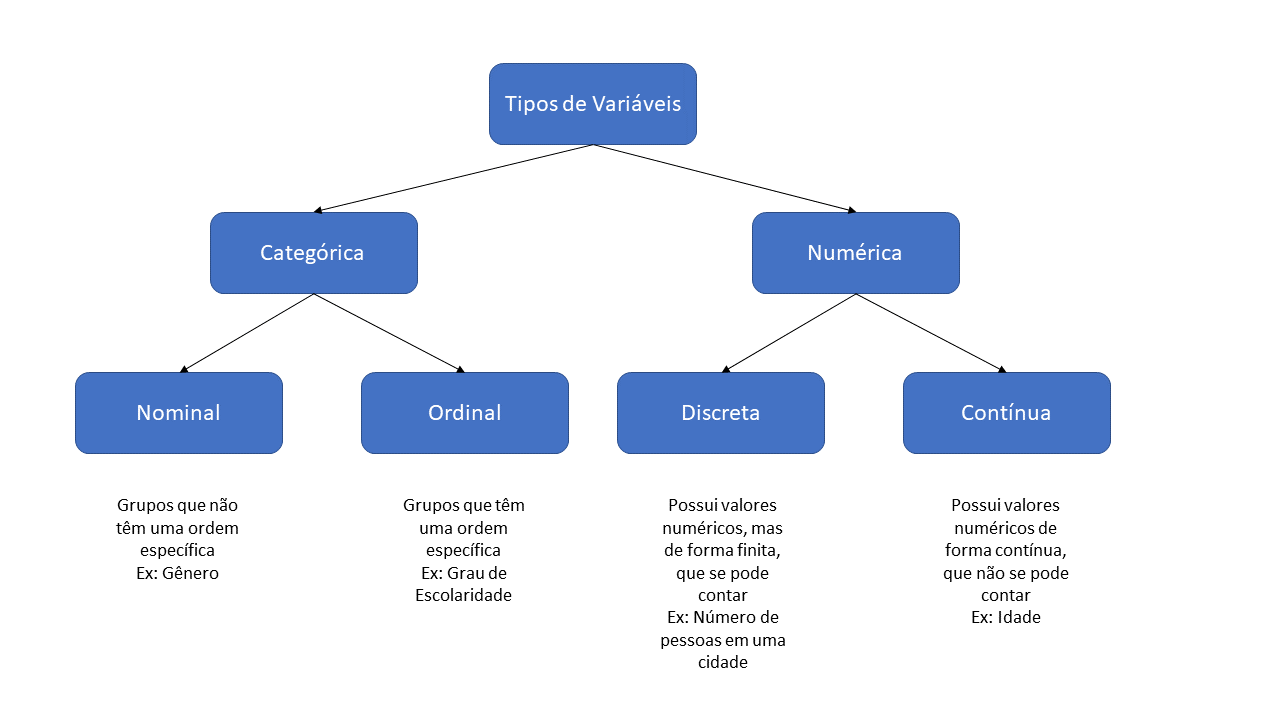

In [5]:
Image(filename='Tipos_de_Variáveis.png', width=1000, height=1000)

In [6]:
def show_null(df):
    null_columns = (df.isnull().sum(axis=0)/len(df)).sort_values(ascending=False).index
    
    null_data = pd.concat([df.isnull().sum(axis=0), 
                           (df.isnull().sum(axis=0)/len(df)).sort_values(ascending=False), 
                           df.loc[:, df.columns.isin(list(null_columns))].dtypes], 
                          axis=1)
    
    null_data = null_data.rename(columns={0: '#', 
                                          1: '% null', 
                                          2: 'type'}).sort_values(ascending=False, 
                                                                  by='% null')
    
    return null_data

In [8]:
def plot_num(df, feature): #Df = base, feature = coluna
    fig = plt.figure(figsize=(12,8))
    gs = GridSpec(1,2)  #Grid 1 linha e 2 colunas
    sns.boxplot(y=feature, data=df, color='firebrick', ax=fig.add_subplot(gs[0,0])) #linha 1 coluna 1
    plt.ylabel(feature)
    sns.stripplot(y=df[feature], color='orangered', ax=fig.add_subplot(gs[0,1])) #linha 1 coluna 2
    plt.ylabel(None)
    plt.show()

In [10]:
def plot_cat(df, feature):
    fig = plt.figure(figsize=(12,8))
    ax = sns.countplot(data=df, x=feature)
    for p in ax.patches: #Coloca o valor da feature
        
        ax.annotate(f'\n{p.get_height()}', 
                    (p.get_x()+0.4, p.get_height()+8), 
                    ha='center', 
                    color='black')
        
    plt.xlabel('\n \n' + feature)
    plt.ylabel('Quantidade de Clientes')
    plt.show()

#### People - Tratamento dos dados 

In [13]:
people = df[['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 
             'Recency', 'Complain']]

In [14]:
people.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,Complain
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,0
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,0


In [15]:
show_null(people)

,#,% null,type
Income,24,0.010714,float64
ID,0,0.000000,int64
Year_Birth,0,0.000000,int64
Education,0,0.000000,object
Marital_Status,0,0.000000,object
Kidhome,0,0.000000,int64
Teenhome,0,0.000000,int64
Dt_Customer,0,0.000000,object
Recency,0,0.000000,int64
Complain,0,0.000000,int64


##### Income

In [16]:
#Exclui os registros nulos da variavel Income 1,07% dos registros - Conforme mostrado acima
people.dropna(inplace=True) 

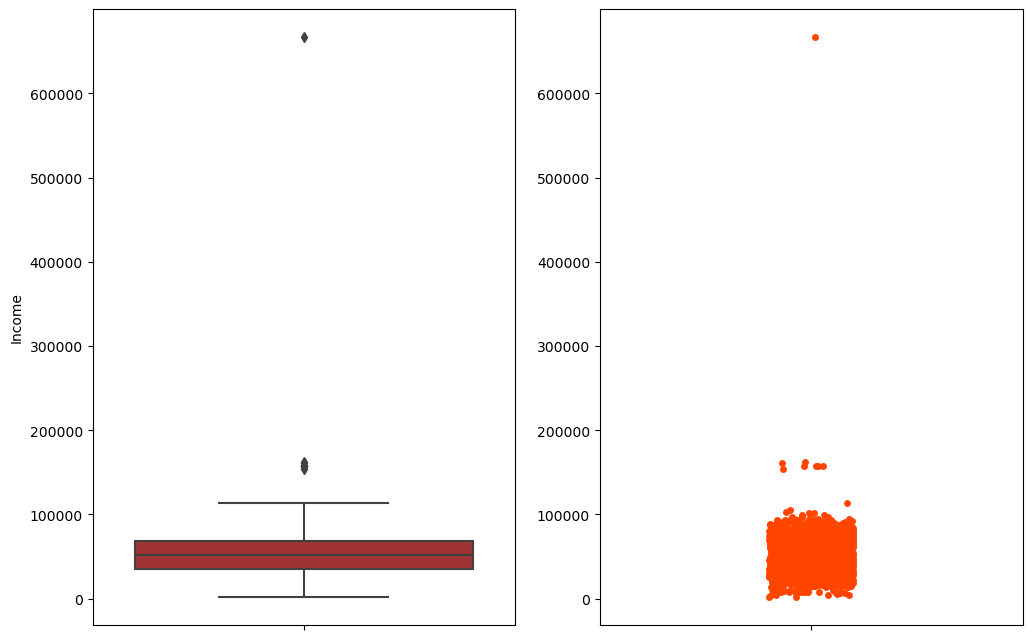

In [17]:
plot_num(people, 'Income')

In [18]:
#Só plot os registros onde Income é menor que 200000
people = people[people.Income < 200000]

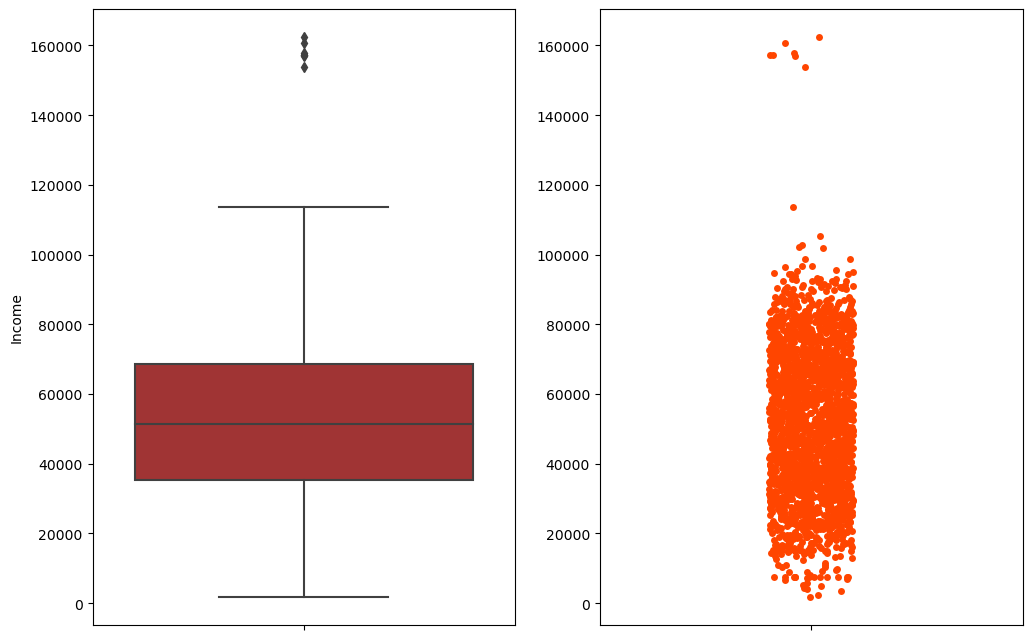

In [19]:
plot_num(people, 'Income')

##### Year_Birth

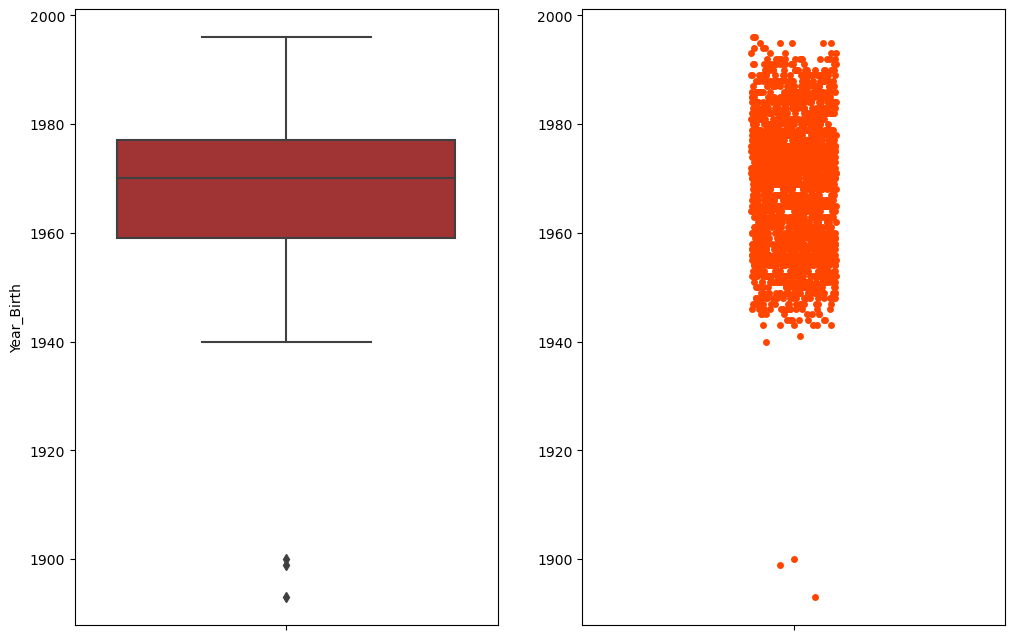

In [20]:
plot_num(people, 'Year_Birth')

In [21]:
people = people[people.Year_Birth > 1930]

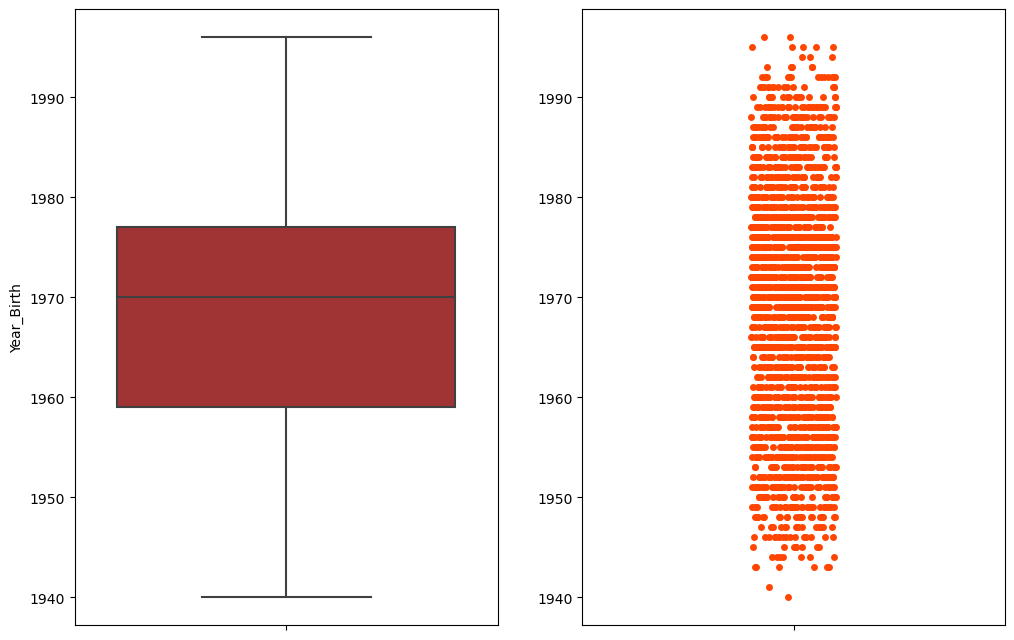

In [22]:
plot_num(people, 'Year_Birth')

##### Education

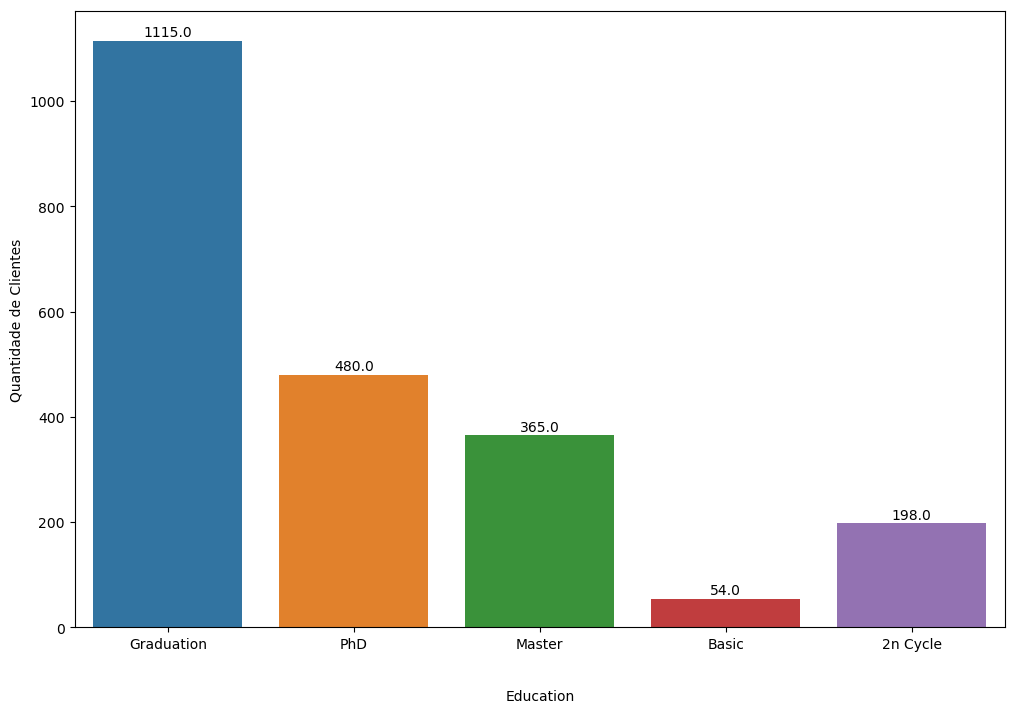

In [23]:
plot_cat(people, 'Education')

In [94]:
people.Education = people.Education.apply(lambda x: 0 if x=='Basic' 
                       else(1 if x=='2n Cycle' 
                            else(2 if x=='Graduation' 
                                 else(3 if x =='Master' 
                                      else(4 if x=='PhD' else None)))))

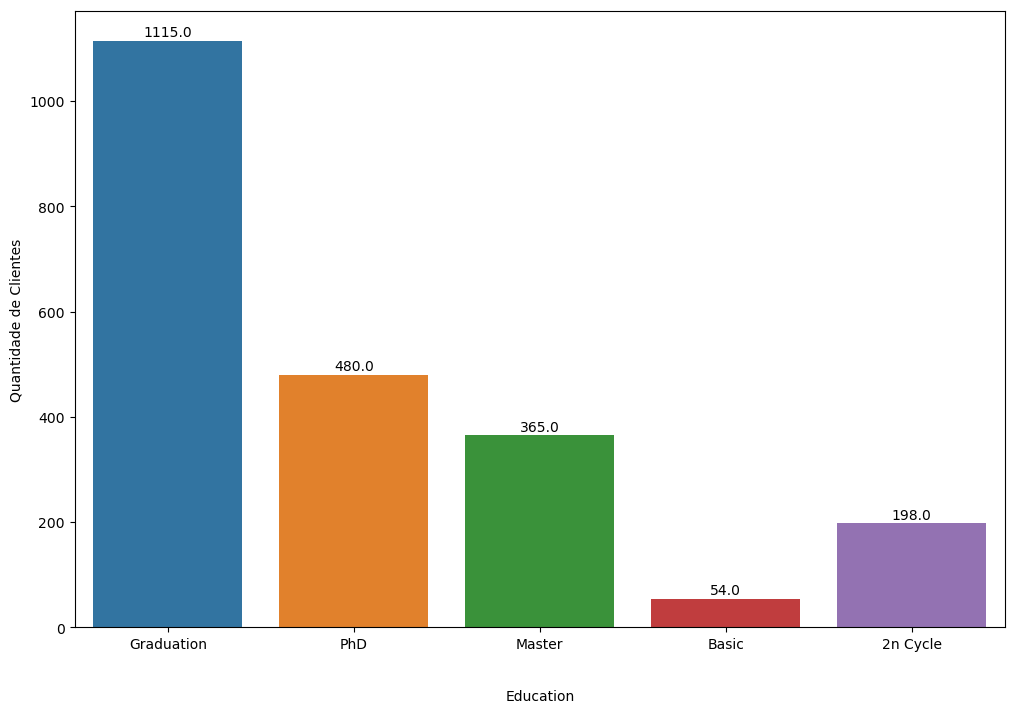

In [24]:
plot_cat(people, 'Education')

##### Marital_Status

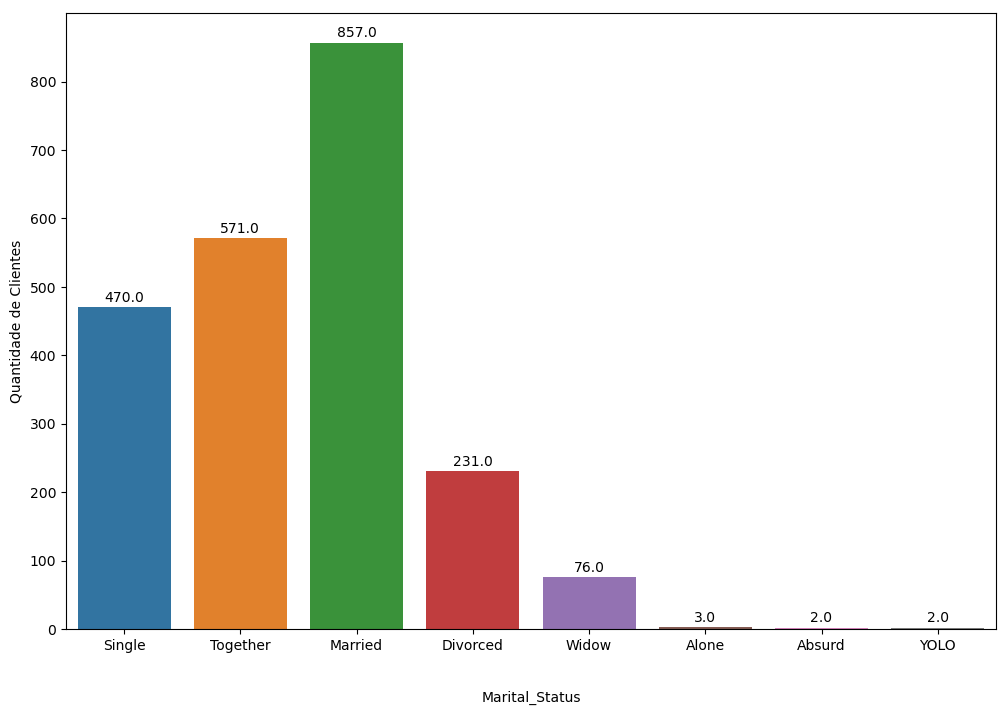

In [25]:
plot_cat(people, 'Marital_Status')

In [26]:
people = people[people.Marital_Status != 'Absurd']

In [27]:
people.Marital_Status = people.Marital_Status.apply(lambda x: 'Single' if x=='Alone' 
                                                    else('Single' if x =='YOLO' else x))

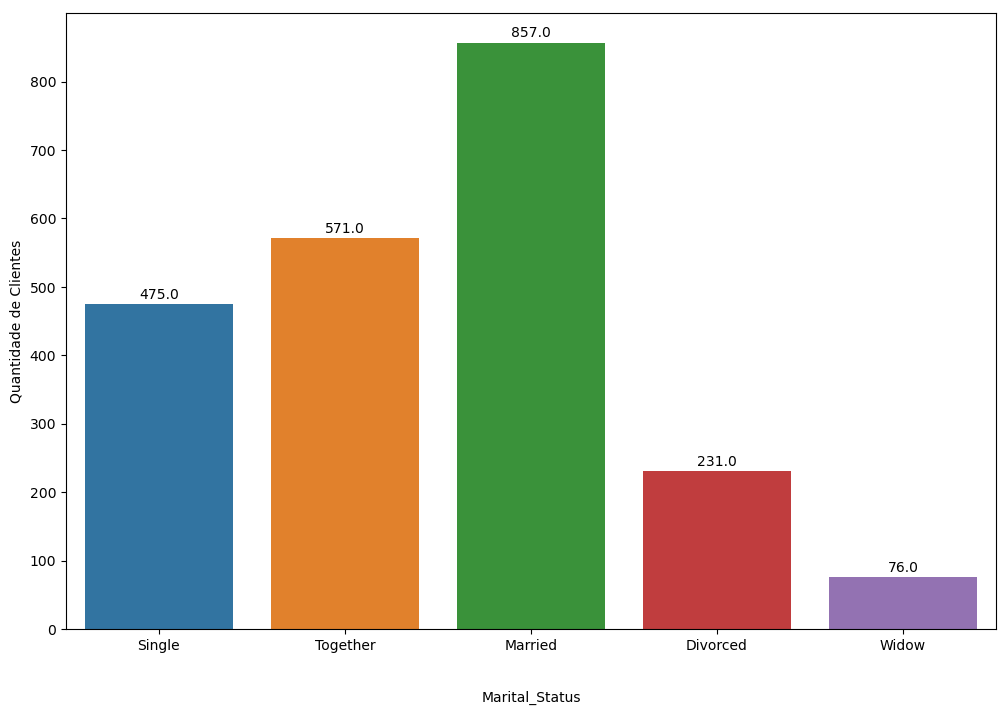

In [28]:
plot_cat(people, 'Marital_Status')

In [29]:
people.Marital_Status = people.Marital_Status.apply(lambda x: 'Together' if x=='Married' else x)

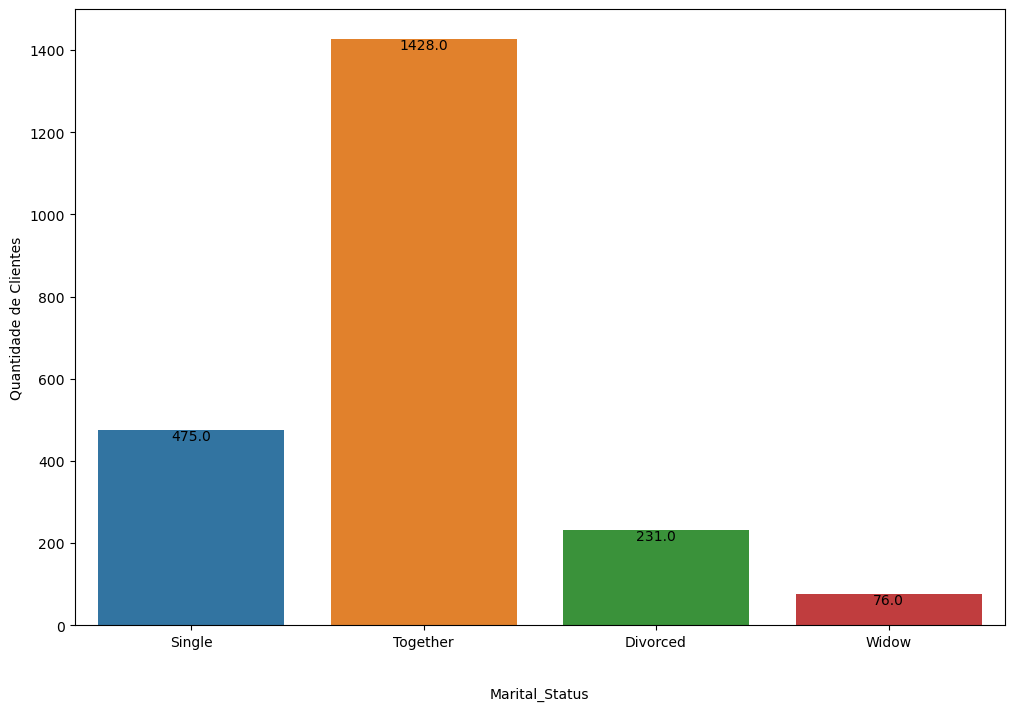

In [101]:
plot_cat(people, 'Marital_Status')

In [30]:
people.dtypes

ID                  int64
Year_Birth          int64
Education          object
Marital_Status     object
Income            float64
Kidhome             int64
Teenhome            int64
Dt_Customer        object
Recency             int64
Complain            int64
dtype: object

In [31]:
# Transformando em datetime
people.Dt_Customer = pd.to_datetime(people.Dt_Customer, dayfirst=True)

In [32]:
# Variavel Marital_status precisa ser dummificada - não existe hierarquia
people = pd.get_dummies(people)

In [33]:
people

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,Complain,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,5524,1957,58138.0,0,0,2012-09-04,58,0,0,0,1,0,0,0,1,0,0
1,2174,1954,46344.0,1,1,2014-03-08,38,0,0,0,1,0,0,0,1,0,0
2,4141,1965,71613.0,0,0,2013-08-21,26,0,0,0,1,0,0,0,0,1,0
3,6182,1984,26646.0,1,0,2014-02-10,26,0,0,0,1,0,0,0,0,1,0
4,5324,1981,58293.0,1,0,2014-01-19,94,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,61223.0,0,1,2013-06-13,46,0,0,0,1,0,0,0,0,1,0
2236,4001,1946,64014.0,2,1,2014-06-10,56,0,0,0,0,0,1,0,0,1,0
2237,7270,1981,56981.0,0,0,2014-01-25,91,0,0,0,1,0,0,1,0,0,0
2238,8235,1956,69245.0,0,1,2014-01-24,8,0,0,0,0,1,0,0,0,1,0


##### Kidhome

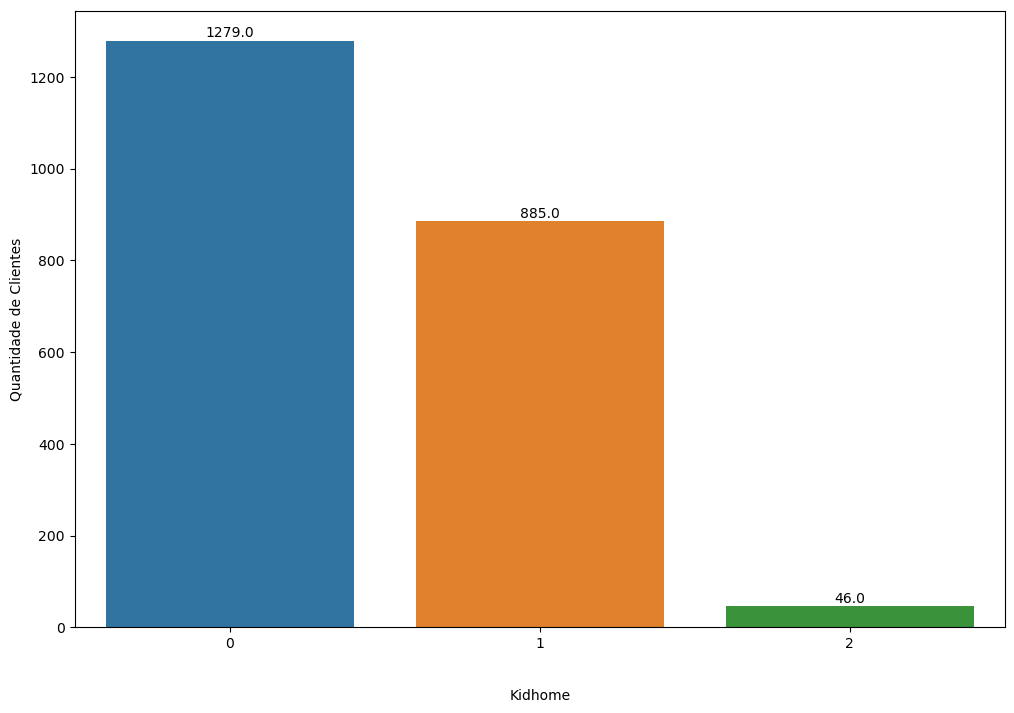

In [34]:
plot_cat(people, 'Kidhome')

##### TeenHome

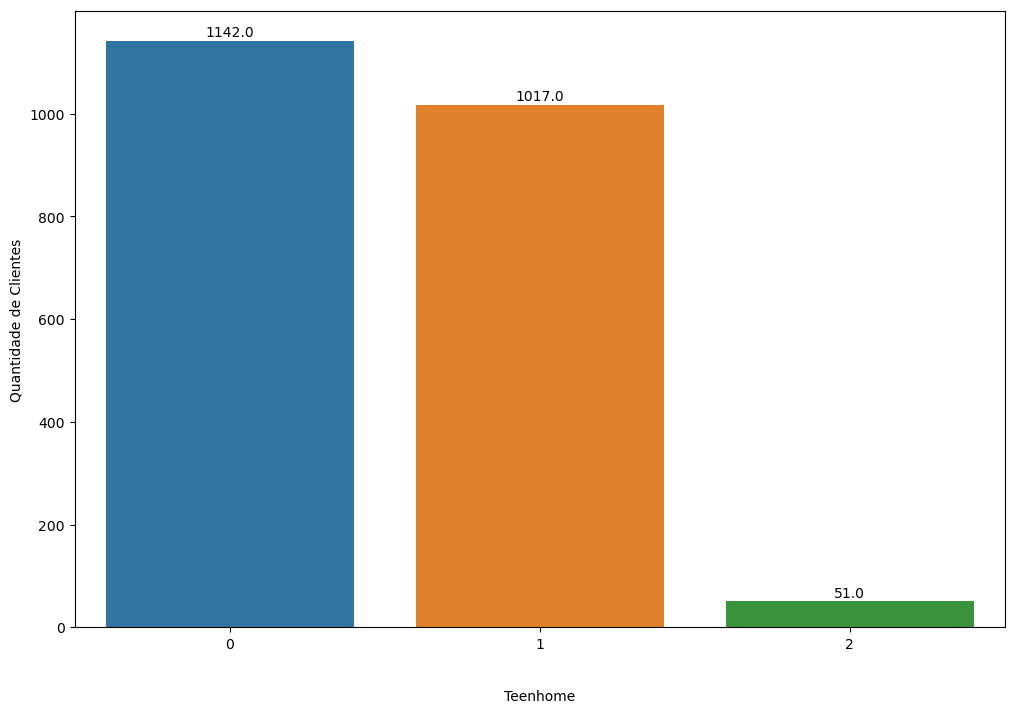

In [35]:
plot_cat(people, 'Teenhome')

##### ChildrenHome

In [36]:
people['ChildrenHome'] = people.Kidhome + people.Teenhome

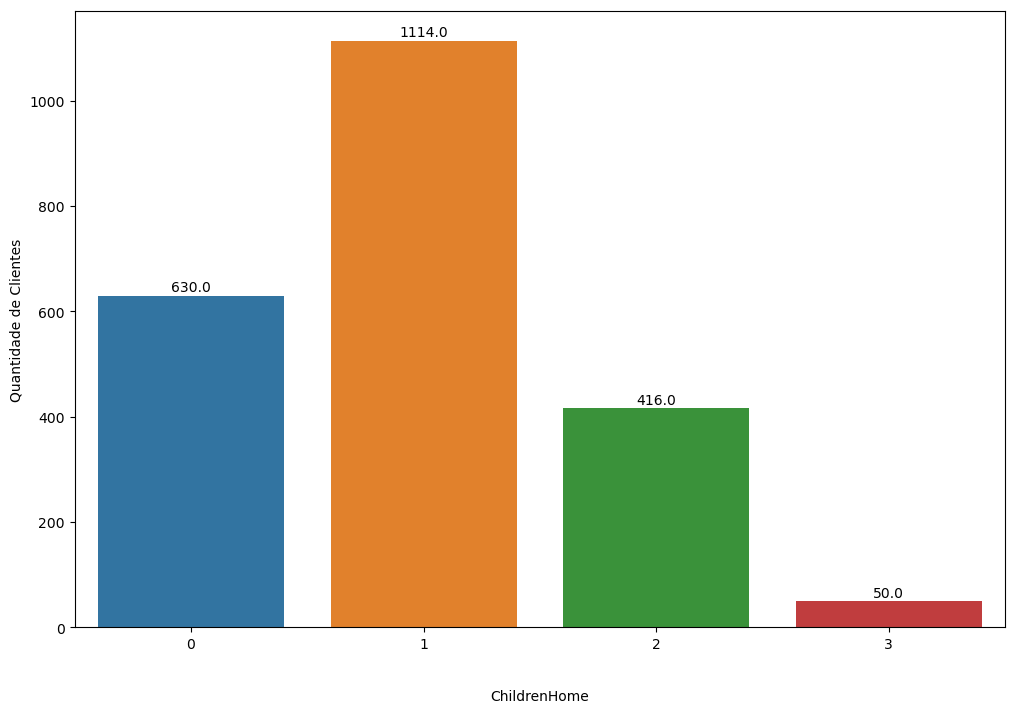

In [37]:
plot_cat(people, 'ChildrenHome')

In [38]:
people.drop(columns=['Kidhome', 'Teenhome'], inplace=True)

In [39]:
people.head()

,ID,Year_Birth,Income,Dt_Customer,Recency,Complain,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome
0,5524,1957,58138.0,2012-09-04,58,0,0,0,1,0,0,0,1,0,0,0
1,2174,1954,46344.0,2014-03-08,38,0,0,0,1,0,0,0,1,0,0,2
2,4141,1965,71613.0,2013-08-21,26,0,0,0,1,0,0,0,0,1,0,0
3,6182,1984,26646.0,2014-02-10,26,0,0,0,1,0,0,0,0,1,0,1
4,5324,1981,58293.0,2014-01-19,94,0,0,0,0,0,1,0,0,1,0,1


##### Dt_Customer

In [40]:
people.Dt_Customer.min()

Timestamp('2012-07-30 00:00:00')

In [41]:
people.Dt_Customer.max()

Timestamp('2014-06-29 00:00:00')

In [42]:
(people['Dt_Customer'] + pd.to_timedelta(people['Recency'], unit='d')).max()

Timestamp('2014-10-04 00:00:00')

In [43]:
people['LifeTime'] = (pd.to_datetime('2014-10-05') - people['Dt_Customer']).dt.days/30

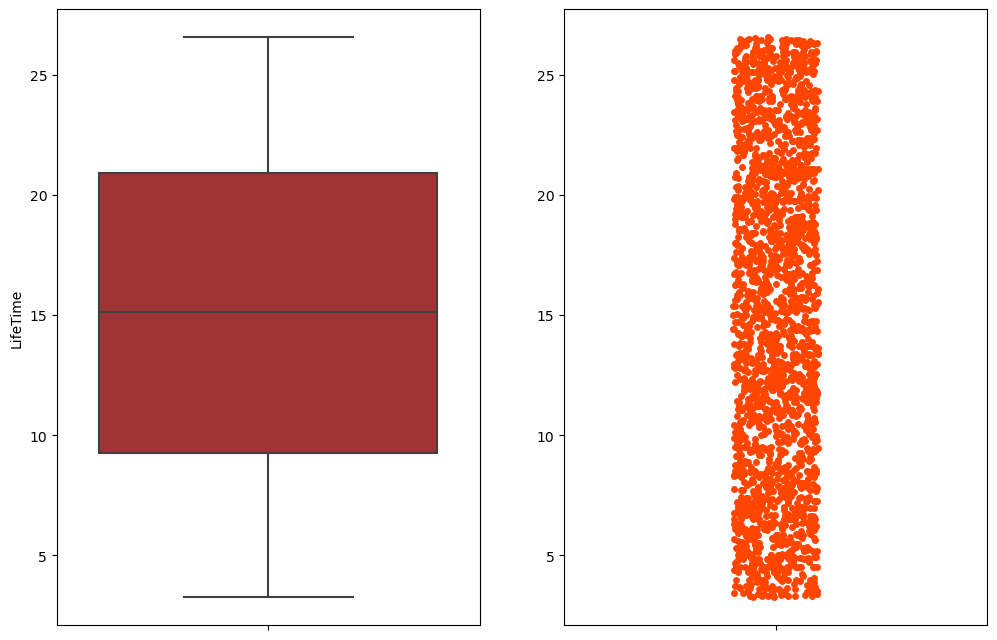

In [44]:
plot_num(people, 'LifeTime')

In [45]:
people.columns

Index(['ID', 'Year_Birth', 'Income', 'Dt_Customer', 'Recency', 'Complain',
       'Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Marital_Status_Divorced',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'ChildrenHome', 'LifeTime'],
      dtype='object')

##### Recency

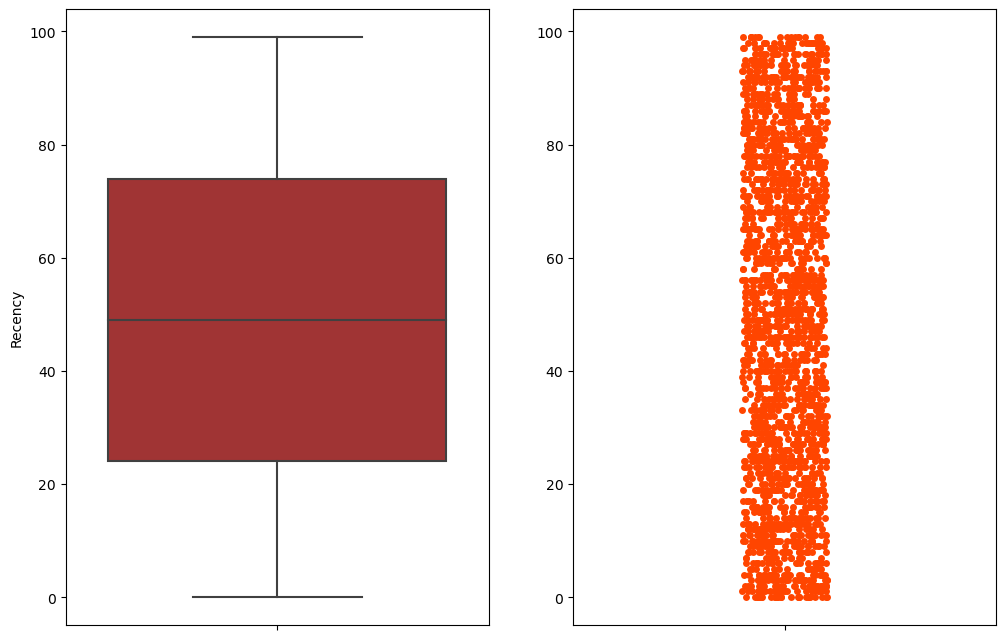

In [46]:
plot_num(people, 'Recency')

##### Complain

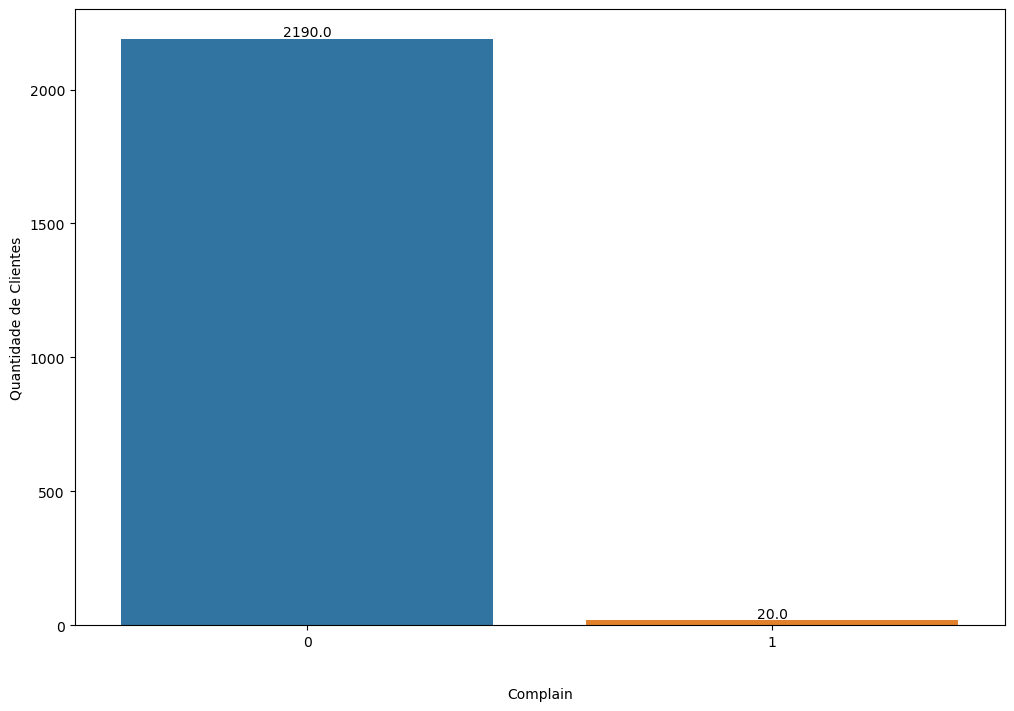

In [47]:
plot_cat(people, 'Complain')

In [48]:
people.drop(columns=['Complain'], inplace=True)

In [49]:
people.head()

,ID,Year_Birth,Income,Dt_Customer,Recency,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome,LifeTime
0,5524,1957,58138.0,2012-09-04,58,0,0,1,0,0,0,1,0,0,0,25.366667
1,2174,1954,46344.0,2014-03-08,38,0,0,1,0,0,0,1,0,0,2,7.033333
2,4141,1965,71613.0,2013-08-21,26,0,0,1,0,0,0,0,1,0,0,13.666667
3,6182,1984,26646.0,2014-02-10,26,0,0,1,0,0,0,0,1,0,1,7.900000
4,5324,1981,58293.0,2014-01-19,94,0,0,0,0,1,0,0,1,0,1,8.633333


In [50]:
people.drop(columns=['Dt_Customer'], inplace=True)

In [51]:
people.columns

Index(['ID', 'Year_Birth', 'Income', 'Recency', 'Education_2n Cycle',
       'Education_Basic', 'Education_Graduation', 'Education_Master',
       'Education_PhD', 'Marital_Status_Divorced', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow', 'ChildrenHome',
       'LifeTime'],
      dtype='object')

#### Products

In [52]:
products = df[['ID','MntWines','MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]

In [53]:
products.head()

,ID,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,5524,635,88,546,172,88,88
1,2174,11,1,6,2,1,6
2,4141,426,49,127,111,21,42
3,6182,11,4,20,10,3,5
4,5324,173,43,118,46,27,15


In [54]:
show_null(products)

,#,% null,type
ID,0,0.0,int64
MntWines,0,0.0,int64
MntFruits,0,0.0,int64
MntMeatProducts,0,0.0,int64
MntFishProducts,0,0.0,int64
MntSweetProducts,0,0.0,int64
MntGoldProds,0,0.0,int64


##### MntWines

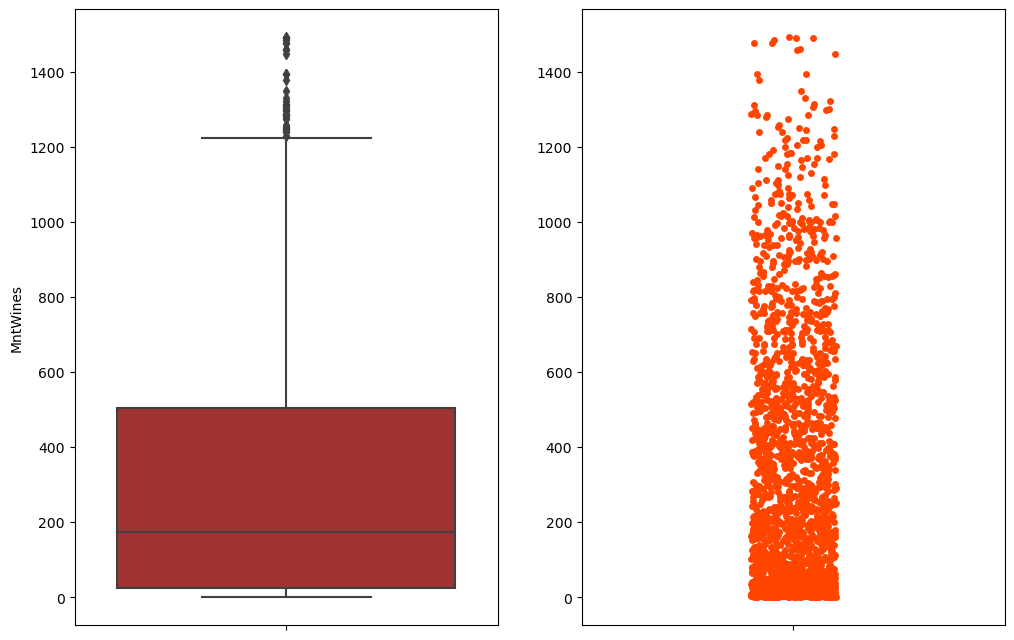

In [55]:
plot_num(products, 'MntWines')

##### MntFruits

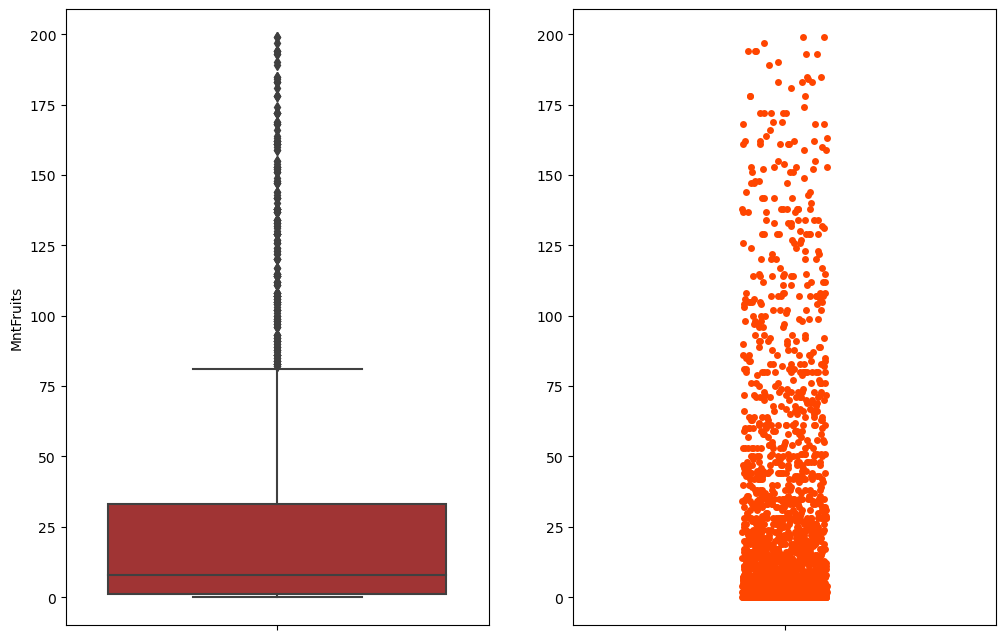

In [56]:
plot_num(products, 'MntFruits')

##### MntMeatProducts

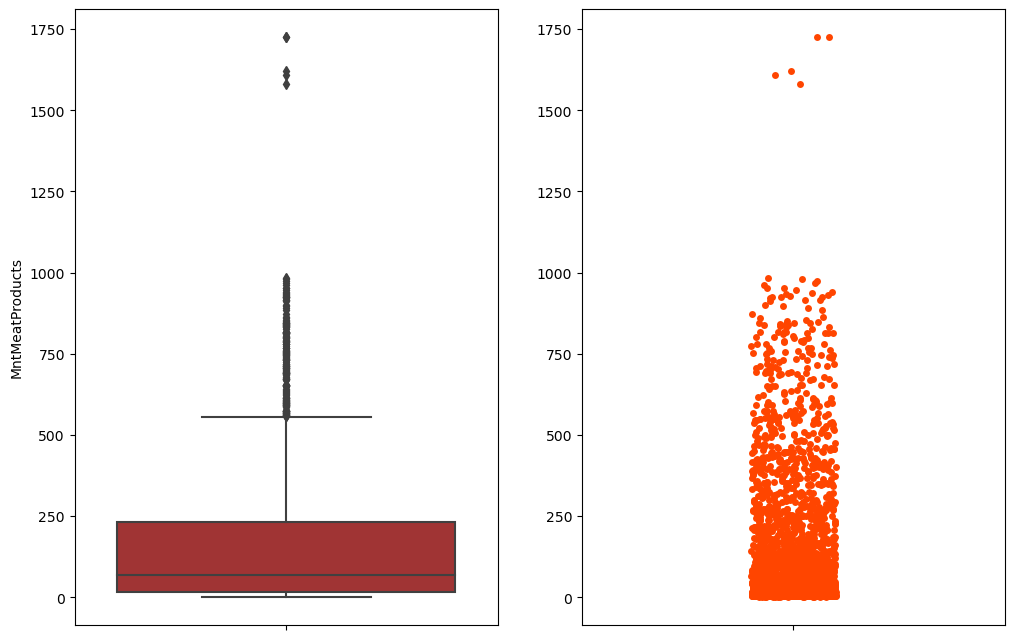

In [133]:
plot_num(products, 'MntMeatProducts')

##### MntFishProducts

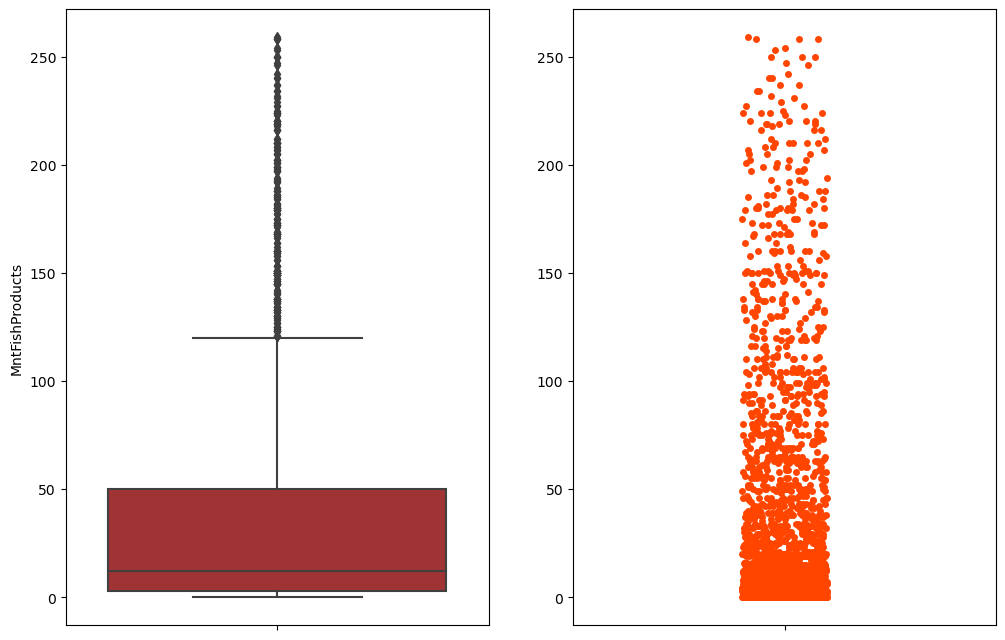

In [134]:
plot_num(products, 'MntFishProducts')

##### MntSweetProducts

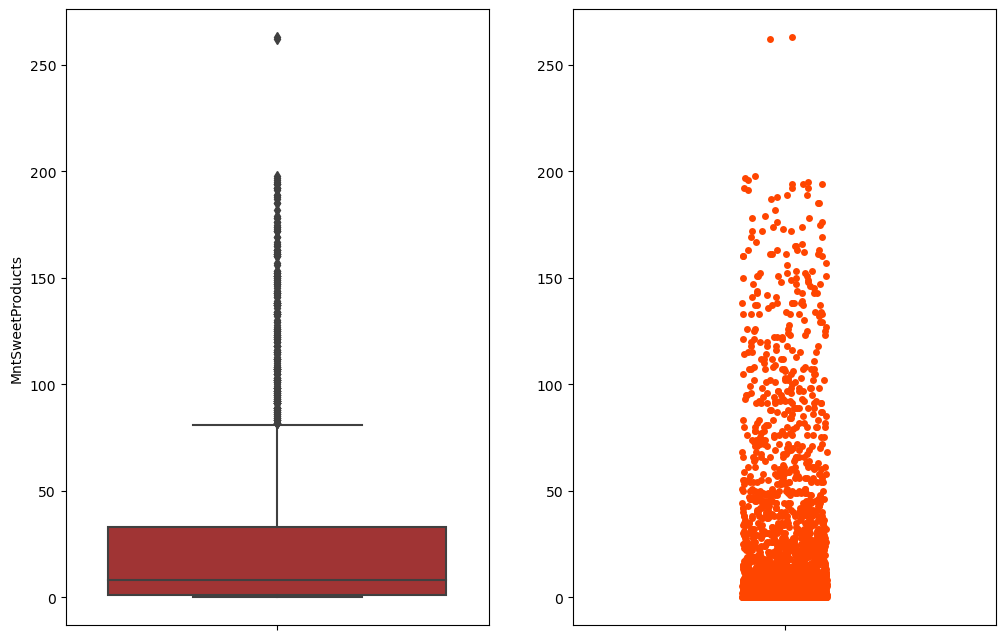

In [135]:
plot_num(products, 'MntSweetProducts')

##### MntGoldProds

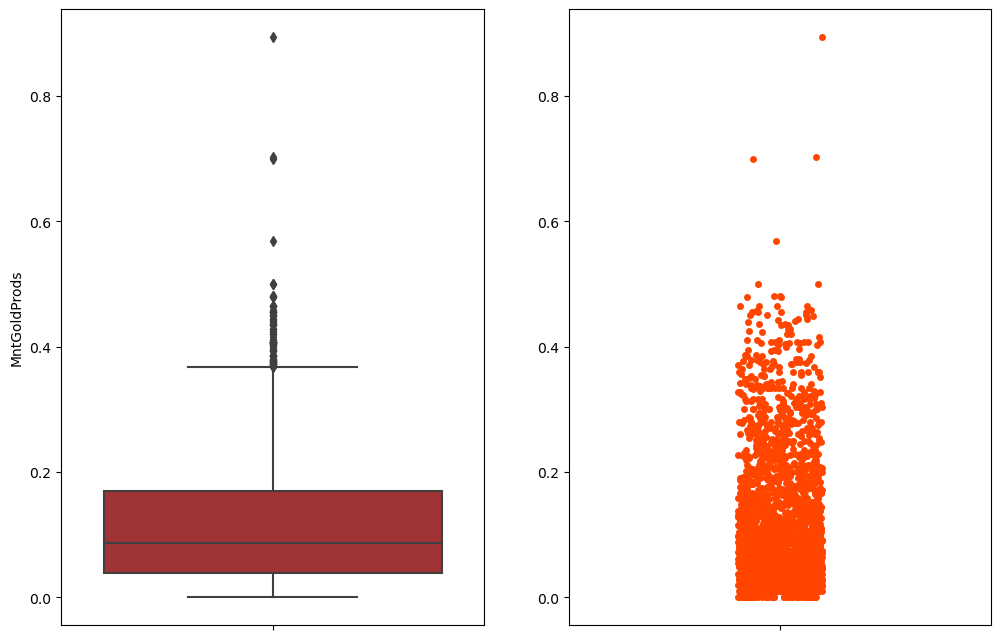

In [141]:
plot_num(products, 'MntGoldProds')

In [137]:
products['TotalAmountSpent'] = products.MntFishProducts + products.MntFruits + products.MntGoldProds \
+ products.MntMeatProducts + products.MntSweetProducts + products.MntWines

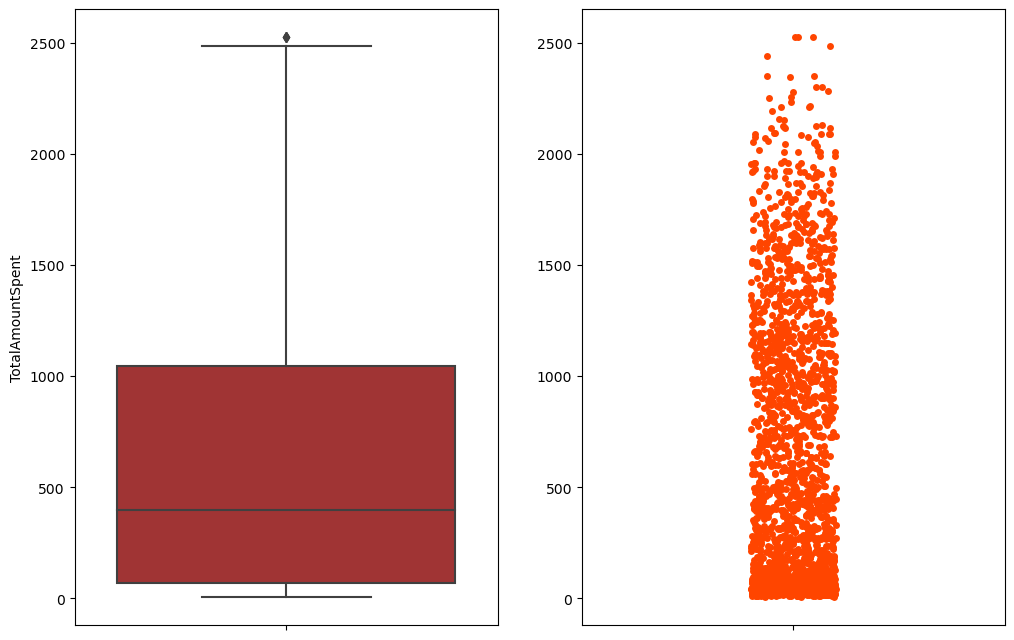

In [138]:
plot_num(products, 'TotalAmountSpent')

In [139]:
products.MntFishProducts = products.MntFishProducts/products['TotalAmountSpent']
products.MntFruits = products.MntFruits/products['TotalAmountSpent']
products.MntGoldProds = products.MntGoldProds/products['TotalAmountSpent']
products.MntMeatProducts = products.MntMeatProducts/products['TotalAmountSpent']
products.MntSweetProducts = products.MntSweetProducts/products['TotalAmountSpent']
products.MntWines = products.MntWines/products['TotalAmountSpent']

In [142]:
products.describe()

,ID,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalAmountSpent
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,0.458481,0.049505,0.249508,0.071532,0.050777,0.120196,605.798214
std,3246.662198,0.228411,0.055867,0.126633,0.077909,0.061184,0.108988,602.249288
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,2828.250000,0.289506,0.008924,0.156250,0.012571,0.008621,0.038095,68.750000
50%,5458.500000,0.457482,0.029840,0.233447,0.048193,0.033333,0.086294,396.000000
75%,8427.750000,0.639143,0.070237,0.328227,0.104703,0.070411,0.169768,1045.500000
max,11191.000000,0.963303,0.445545,0.997110,0.590909,0.945848,0.894150,2525.000000


In [143]:
products.head()

,ID,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalAmountSpent
0,5524,0.392703,0.054422,0.337662,0.106370,0.054422,0.054422,1617
1,2174,0.407407,0.037037,0.222222,0.074074,0.037037,0.222222,27
2,4141,0.548969,0.063144,0.163660,0.143041,0.027062,0.054124,776
3,6182,0.207547,0.075472,0.377358,0.188679,0.056604,0.094340,53
4,5324,0.409953,0.101896,0.279621,0.109005,0.063981,0.035545,422


#### Promotion

In [144]:
promotion = df[['ID','AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 
                'AcceptedCmp5', 'Response']]

In [145]:
promotion.head()

,ID,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
0,5524,0,0,0,0,0,1
1,2174,0,0,0,0,0,0
2,4141,0,0,0,0,0,0
3,6182,0,0,0,0,0,0
4,5324,0,0,0,0,0,0


In [66]:
show_null(promotion)

,#,% null,type
ID,0,0.0,int64
AcceptedCmp1,0,0.0,int64
AcceptedCmp2,0,0.0,int64
AcceptedCmp3,0,0.0,int64
AcceptedCmp4,0,0.0,int64
AcceptedCmp5,0,0.0,int64
Response,0,0.0,int64


In [146]:
promotion.describe()

,ID,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,0.064286,0.013393,0.072768,0.074554,0.072768,0.149107
std,3246.662198,0.245316,0.114976,0.259813,0.262728,0.259813,0.356274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5458.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8427.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11191.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [147]:
promotion['AcceptedCmp'] = promotion.AcceptedCmp1 + promotion.AcceptedCmp2 + promotion.AcceptedCmp3 + promotion.AcceptedCmp4 + \
promotion.AcceptedCmp5 + promotion.Response

In [148]:
promotion['AcceptedCmp'].describe()

count    2240.000000
mean        0.446875
std         0.890543
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: AcceptedCmp, dtype: float64

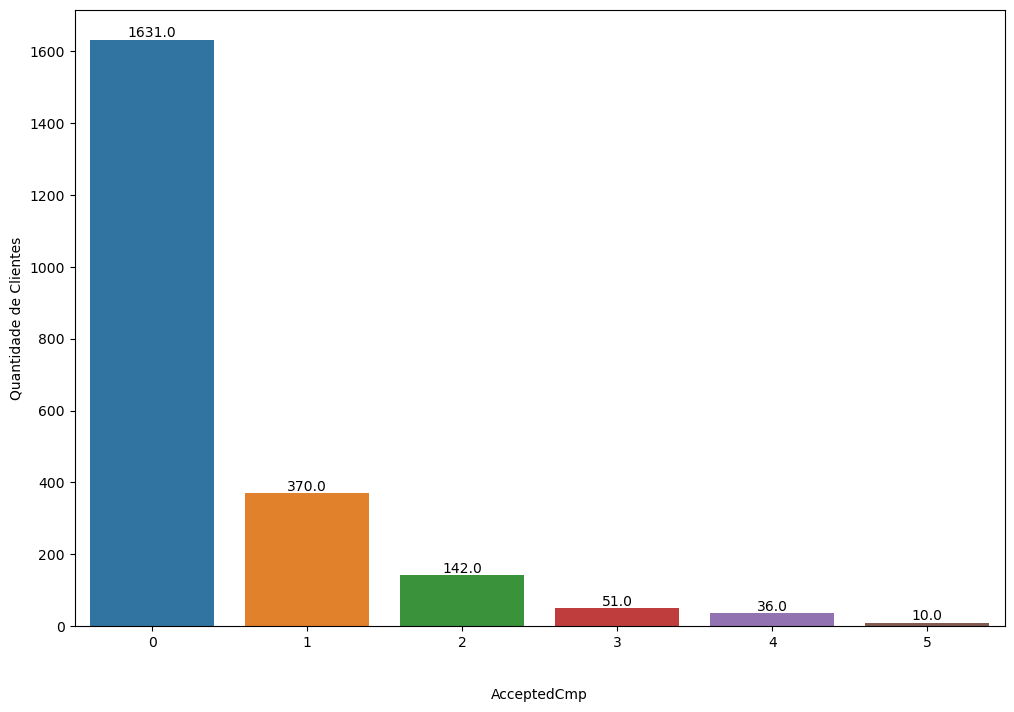

In [149]:
plot_cat(promotion, 'AcceptedCmp')

In [150]:
promotion = promotion[['ID', 'AcceptedCmp']]

In [151]:
promotion.head()

,ID,AcceptedCmp
0,5524,1
1,2174,0
2,4141,0
3,6182,0
4,5324,0


#### Place

In [152]:
place = df[['ID','NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'NumWebVisitsMonth']]

In [153]:
place.head()

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth
0,5524,8,10,4,3,7
1,2174,1,1,2,2,5
2,4141,8,2,10,1,4
3,6182,2,0,4,2,6
4,5324,5,3,6,5,5


In [154]:
show_null(place)

,#,% null,type
ID,0,0.0,int64
NumWebPurchases,0,0.0,int64
NumCatalogPurchases,0,0.0,int64
NumStorePurchases,0,0.0,int64
NumDealsPurchases,0,0.0,int64
NumWebVisitsMonth,0,0.0,int64


In [155]:
place['TotalPurchases'] = place.NumWebPurchases + place.NumCatalogPurchases + place.NumStorePurchases

In [156]:
place.describe()

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,4.084821,2.662054,5.790179,2.325000,5.316518,12.537054
std,3246.662198,2.778714,2.923101,3.250958,1.932238,2.426645,7.205741
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,2.000000,0.000000,3.000000,1.000000,3.000000,6.000000
50%,5458.500000,4.000000,2.000000,5.000000,2.000000,6.000000,12.000000
75%,8427.750000,6.000000,4.000000,8.000000,3.000000,7.000000,18.000000
max,11191.000000,27.000000,28.000000,13.000000,15.000000,20.000000,32.000000


In [159]:
place[place.TotalPurchases == 0]

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases


In [158]:
place = place[place['TotalPurchases']>0]

In [160]:
# Porcentagens de compras feitas por locais
place['NumWebPurchases'] = place['NumWebPurchases']/place['TotalPurchases']
place['NumCatalogPurchases'] = place['NumCatalogPurchases']/place['TotalPurchases']
place['NumStorePurchases'] = place['NumStorePurchases']/place['TotalPurchases']
place['NumDealsPurchases'] = place['NumDealsPurchases']/place['TotalPurchases']

In [164]:
place.describe()

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
count,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000
mean,5583.114644,0.330022,0.164435,0.505543,0.241357,5.294671,12.575907
std,3244.053607,0.121685,0.139584,0.149135,0.172430,2.355702,7.183444
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2815.000000,0.250000,0.000000,0.407407,0.083333,3.000000,6.000000
50%,5453.000000,0.333333,0.150000,0.500000,0.200000,6.000000,12.000000
75%,8418.000000,0.400000,0.250000,0.600000,0.333333,7.000000,18.000000
max,11191.000000,1.000000,1.000000,1.000000,1.000000,20.000000,32.000000


In [165]:
# O describe acima só pode ter a max = 1 → 100% o que estiver fora disso provavelmente é um erro e precisa ser elimminado, exceto o NumWebVisitsMonth
place[place.NumDealsPurchases > 1]

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases


In [163]:
place = place[place['NumDealsPurchases']<=1]

##### NumWebPurchases

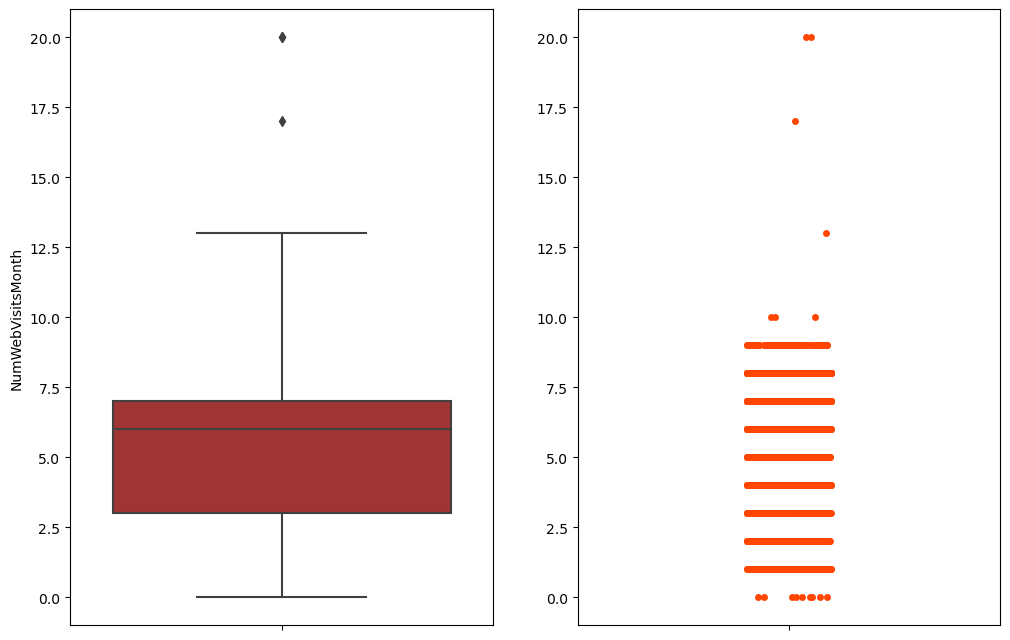

In [166]:
plot_num(place, 'NumWebVisitsMonth')

In [168]:
#Verificando os outliers
place[place.NumWebVisitsMonth > 13]

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
9,5899,1.0,0.0,0.0,1.0,20,1
774,4303,0.0,0.0,1.0,0.0,20,1
1328,4246,0.5,0.0,0.5,0.0,17,2


### Juntando Dados

In [170]:
#Lista de todas as tabelas criadas anteriormente (já tratadas)
df_lista = [people, products, promotion, place]

In [171]:
#merge = join do SQL → de 2 em 2 
df_final = reduce(lambda df1, df2: pd.merge(df1, df2, on='ID'), df_lista)

In [172]:
df_final.shape

(2203, 25)

In [173]:
df_final.columns

Index(['ID', 'Year_Birth', 'Education', 'Income', 'Recency',
       'Marital_Status_Divorced', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow', 'ChildrenHome',
       'LifeTime', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'TotalAmountSpent', 'AcceptedCmp', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases',
       'NumWebVisitsMonth', 'TotalPurchases'],
      dtype='object')

In [89]:
#Eliminando o id para começar o treinamento → aqui termina a limpesa
df_final.drop(columns=['ID'], inplace=True)

### Normalização

In [174]:
#Normaliza todas as variaveis do data set
def scaler(df):
    df2 = df.copy()
    for column in df2:
        minimo = df2[column].min()
        maximo = df2[column].max()
        df2[column] = (df[column] - minimo)/(maximo - minimo)
    return df2

In [175]:
scaled_df = scaler(df_final)

In [176]:
scaled_df.describe()

,ID,Year_Birth,Education,Income,Recency,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome,...,MntSweetProducts,MntGoldProds,TotalAmountSpent,AcceptedCmp,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
count,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,...,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000
mean,0.498217,0.516179,0.615070,0.309517,0.494858,0.103495,0.214707,0.647299,0.034498,0.316689,...,0.053607,0.134151,0.238604,0.089877,0.330002,0.164580,0.505419,0.241032,0.265138,0.374255
std,0.290047,0.208790,0.251205,0.132629,0.292626,0.304674,0.410712,0.477919,0.182547,0.249584,...,0.064434,0.121894,0.239412,0.178555,0.120862,0.139301,0.148665,0.172198,0.117599,0.231731
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.251005,0.339286,0.500000,0.205796,0.242424,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009126,0.042521,0.024235,0.000000,0.250000,0.000000,0.400000,0.083333,0.150000,0.161290
50%,0.486194,0.535714,0.500000,0.305883,0.494949,0.000000,0.000000,1.000000,0.000000,0.333333,...,0.034950,0.094632,0.154946,0.000000,0.333333,0.150000,0.500000,0.200000,0.300000,0.354839
75%,0.751944,0.660714,0.750000,0.412801,0.747475,0.000000,0.000000,1.000000,0.000000,0.333333,...,0.074329,0.189881,0.413190,0.200000,0.400000,0.250000,0.600000,0.333333,0.350000,0.580645
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Método de Elbow

In [187]:
# Utilizado para achar o melhor numero de cluster para esse dataser
inertia = []
num_clusters = range(1, 14)

for k in num_clusters:
    Model = KMeans(n_clusters=k)
    Model.fit(scaled_df)
    inertia.append(Model.inertia_)

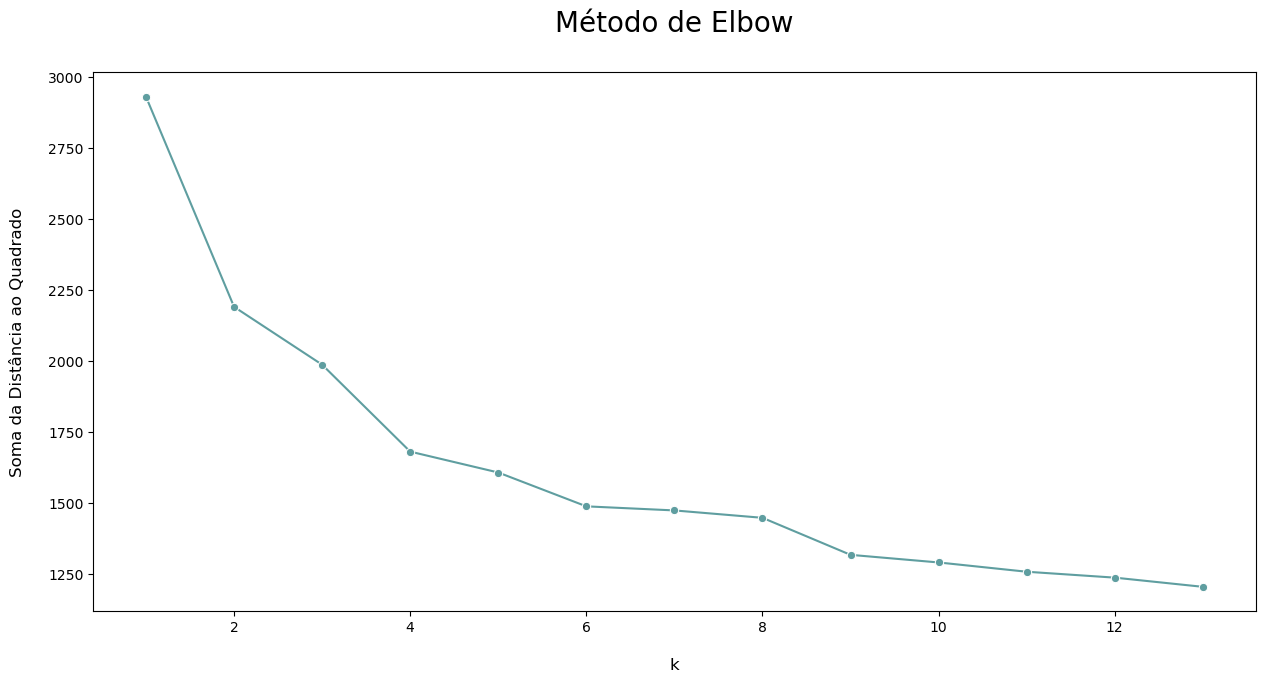

In [188]:
plt.figure(figsize=(15,7))
sns.lineplot(x=num_clusters, y=inertia, color='cadetblue', marker='o')
plt.xlabel('\nk', size=12)
plt.ylabel('Soma da Distância ao Quadrado\n', size=12)
plt.title('Método de Elbow\n', size=20)
plt.show()

### Alocação de Pesos

In [189]:
scaled_df.columns

Index(['ID', 'Year_Birth', 'Education', 'Income', 'Recency',
       'Marital_Status_Divorced', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow', 'ChildrenHome',
       'LifeTime', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'TotalAmountSpent', 'AcceptedCmp', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases',
       'NumWebVisitsMonth', 'TotalPurchases'],
      dtype='object')

In [190]:
scaled_df.TotalAmountSpent = 8*scaled_df.TotalAmountSpent
scaled_df.TotalPurchases = 6*scaled_df.TotalPurchases
scaled_df.Recency = 4*scaled_df.Recency
scaled_df.NumWebVisitsMonth = 4*scaled_df.NumWebVisitsMonth
scaled_df.Income = 4*scaled_df.Income
scaled_df.LifeTime = 4*scaled_df.LifeTime
scaled_df.Year_Birth = 2*scaled_df.Year_Birth
scaled_df.ChildrenHome = 2*scaled_df.ChildrenHome
scaled_df.Education = 2*scaled_df.Education

In [191]:
scaled_df.describe()

,ID,Year_Birth,Education,Income,Recency,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome,...,MntSweetProducts,MntGoldProds,TotalAmountSpent,AcceptedCmp,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
count,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,...,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000
mean,0.498217,1.032358,1.230141,1.238068,1.979431,0.103495,0.214707,0.647299,0.034498,0.633379,...,0.053607,0.134151,1.908833,0.089877,0.330002,0.164580,0.505419,0.241032,1.060554,2.245530
std,0.290047,0.417580,0.502410,0.530515,1.170504,0.304674,0.410712,0.477919,0.182547,0.499168,...,0.064434,0.121894,1.915298,0.178555,0.120862,0.139301,0.148665,0.172198,0.470396,1.390384
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.251005,0.678571,1.000000,0.823182,0.969697,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009126,0.042521,0.193882,0.000000,0.250000,0.000000,0.400000,0.083333,0.600000,0.967742
50%,0.486194,1.071429,1.000000,1.223532,1.979798,0.000000,0.000000,1.000000,0.000000,0.666667,...,0.034950,0.094632,1.239571,0.000000,0.333333,0.150000,0.500000,0.200000,1.200000,2.129032
75%,0.751944,1.321429,1.500000,1.651204,2.989899,0.000000,0.000000,1.000000,0.000000,0.666667,...,0.074329,0.189881,3.305522,0.200000,0.400000,0.250000,0.600000,0.333333,1.400000,3.483871
max,1.000000,2.000000,2.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,6.000000


### Kmeans

In [192]:
Model = KMeans(n_clusters=4)

In [193]:
clusters = Model.fit_predict(scaled_df)

In [194]:
clusters

array([2, 1, 0, ..., 0, 0, 3])

In [195]:
df_final['cluster'] = clusters

In [196]:
df_final

,ID,Year_Birth,Education,Income,Recency,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome,...,MntGoldProds,TotalAmountSpent,AcceptedCmp,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases,cluster
0,5524,1957,2,58138.0,58,0,1,0,0,0,...,0.054422,1617,1,0.363636,0.454545,0.181818,0.136364,7,22,2
1,2174,1954,2,46344.0,38,0,1,0,0,2,...,0.222222,27,0,0.250000,0.250000,0.500000,0.500000,5,4,1
2,4141,1965,2,71613.0,26,0,0,1,0,0,...,0.054124,776,0,0.400000,0.100000,0.500000,0.050000,4,20,0
3,6182,1984,2,26646.0,26,0,0,1,0,1,...,0.094340,53,0,0.333333,0.000000,0.666667,0.333333,6,6,1
4,5324,1981,4,58293.0,94,0,0,1,0,1,...,0.035545,422,0,0.357143,0.214286,0.428571,0.357143,5,14,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,10870,1967,2,61223.0,46,0,0,1,0,1,...,0.184191,1341,0,0.562500,0.187500,0.250000,0.125000,5,16,2
2199,4001,1946,4,64014.0,56,0,0,1,0,3,...,0.018018,444,1,0.533333,0.133333,0.333333,0.466667,7,15,0
2200,7270,1981,2,56981.0,91,1,0,0,0,0,...,0.019339,1241,1,0.111111,0.166667,0.722222,0.055556,6,18,0
2201,8235,1956,3,69245.0,8,0,0,1,0,1,...,0.072361,843,0,0.285714,0.238095,0.476190,0.095238,3,21,0


#### Salvando o modelo

In [197]:
# save the model to disk
filename = 'modelo_finalizado.sav'
pickle.dump(Model, open(filename, 'wb'))

In [198]:
# load the model from disk
Model = pickle.load(open(filename, 'rb'))

### Análise dos Clusters

In [199]:
df_final.cluster.value_counts()

1    980
3    430
2    414
0    379
Name: cluster, dtype: int64

In [200]:
df_final.groupby('cluster').mean()

,ID,Year_Birth,Education,Income,Recency,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome,...,MntSweetProducts,MntGoldProds,TotalAmountSpent,AcceptedCmp,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
cluster,,,,,,,,,,,,,,,,,,,,,
0,5764.905013,1965.878628,2.506596,69848.670185,41.765172,0.092348,0.187335,0.678100,0.042216,0.583113,...,0.051406,0.070707,961.348285,0.459103,0.297936,0.251128,0.450937,0.103128,3.292876,19.005277
1,5590.306122,1971.441837,2.322449,34922.792857,48.153061,0.101020,0.223469,0.652041,0.023469,1.250000,...,0.058867,0.172379,90.850000,0.172449,0.335725,0.075894,0.588381,0.342561,6.320408,5.739796
2,5631.512077,1968.323671,2.591787,75437.582126,52.640097,0.118357,0.229469,0.613527,0.038647,0.391304,...,0.041865,0.053425,1571.649758,1.173913,0.283905,0.294887,0.421208,0.097703,3.862319,20.582126
3,5321.127907,1966.355814,2.606977,52388.427907,53.755814,0.104651,0.204651,0.641860,0.048837,1.127907,...,0.039993,0.107920,550.290698,0.374419,0.389603,0.164958,0.445439,0.269183,6.141860,14.913953


In [201]:
pd.set_option('display.max_columns', None)

In [202]:
df_final.groupby('cluster').mean()

,ID,Year_Birth,Education,Income,Recency,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome,LifeTime,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalAmountSpent,AcceptedCmp,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
cluster,,,,,,,,,,,,,,,,,,,,,,,,,
0,5764.905013,1965.878628,2.506596,69848.670185,41.765172,0.092348,0.187335,0.678100,0.042216,0.583113,9.803166,0.492896,0.048885,0.265142,0.070963,0.051406,0.070707,961.348285,0.459103,0.297936,0.251128,0.450937,0.103128,3.292876,19.005277
1,5590.306122,1971.441837,2.322449,34922.792857,48.153061,0.101020,0.223469,0.652041,0.023469,1.250000,13.323980,0.388004,0.057165,0.239121,0.084464,0.058867,0.172379,90.850000,0.172449,0.335725,0.075894,0.588381,0.342561,6.320408,5.739796
2,5631.512077,1968.323671,2.591787,75437.582126,52.640097,0.118357,0.229469,0.613527,0.038647,0.391304,18.973833,0.510467,0.039822,0.296964,0.057456,0.041865,0.053425,1571.649758,1.173913,0.283905,0.294887,0.421208,0.097703,3.862319,20.582126
3,5321.127907,1966.355814,2.606977,52388.427907,53.755814,0.104651,0.204651,0.641860,0.048837,1.127907,19.934031,0.544447,0.040346,0.211780,0.055514,0.039993,0.107920,550.290698,0.374419,0.389603,0.164958,0.445439,0.269183,6.141860,14.913953


# RESUMO DOS CLUSTERS GERADOS

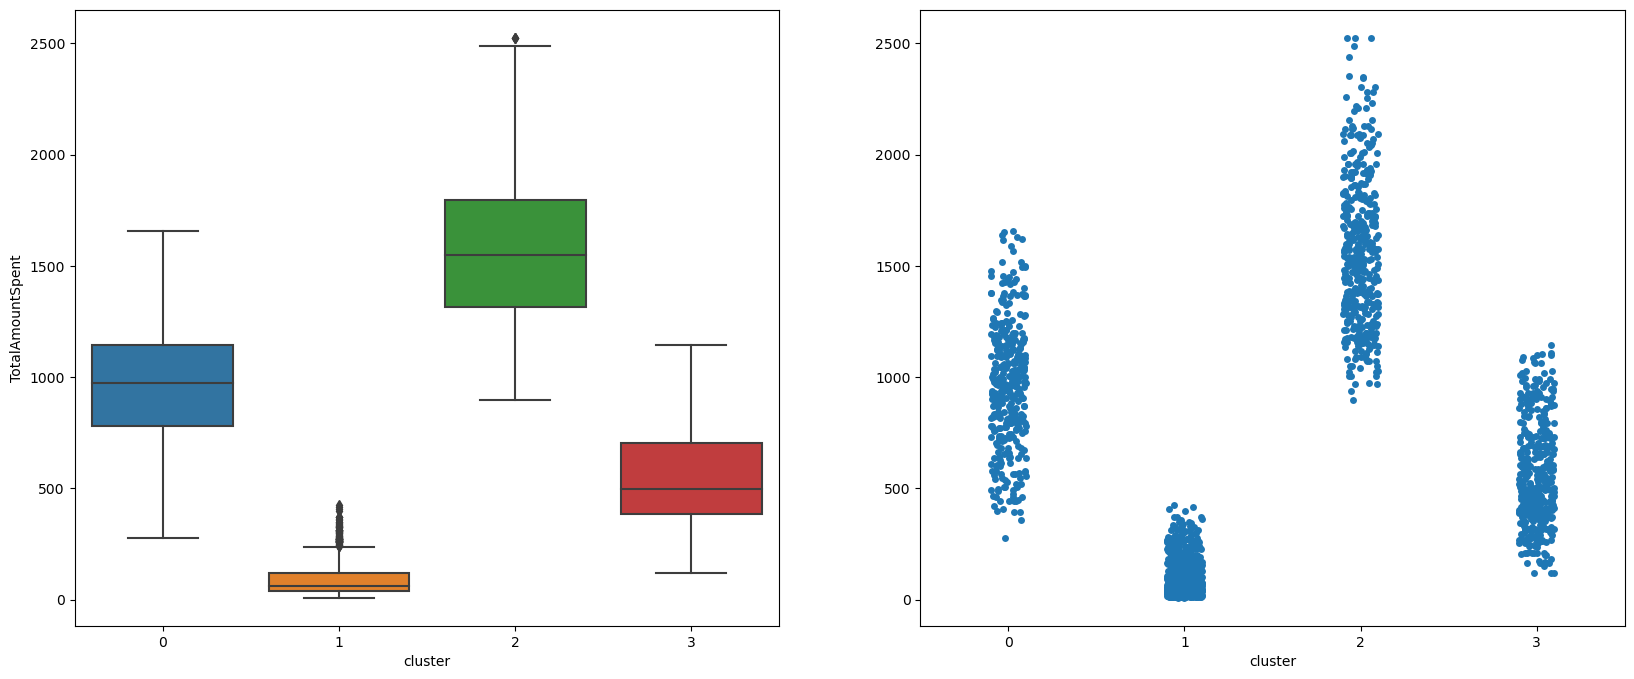

In [203]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='TotalAmountSpent', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('TotalAmountSpent')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='TotalAmountSpent', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

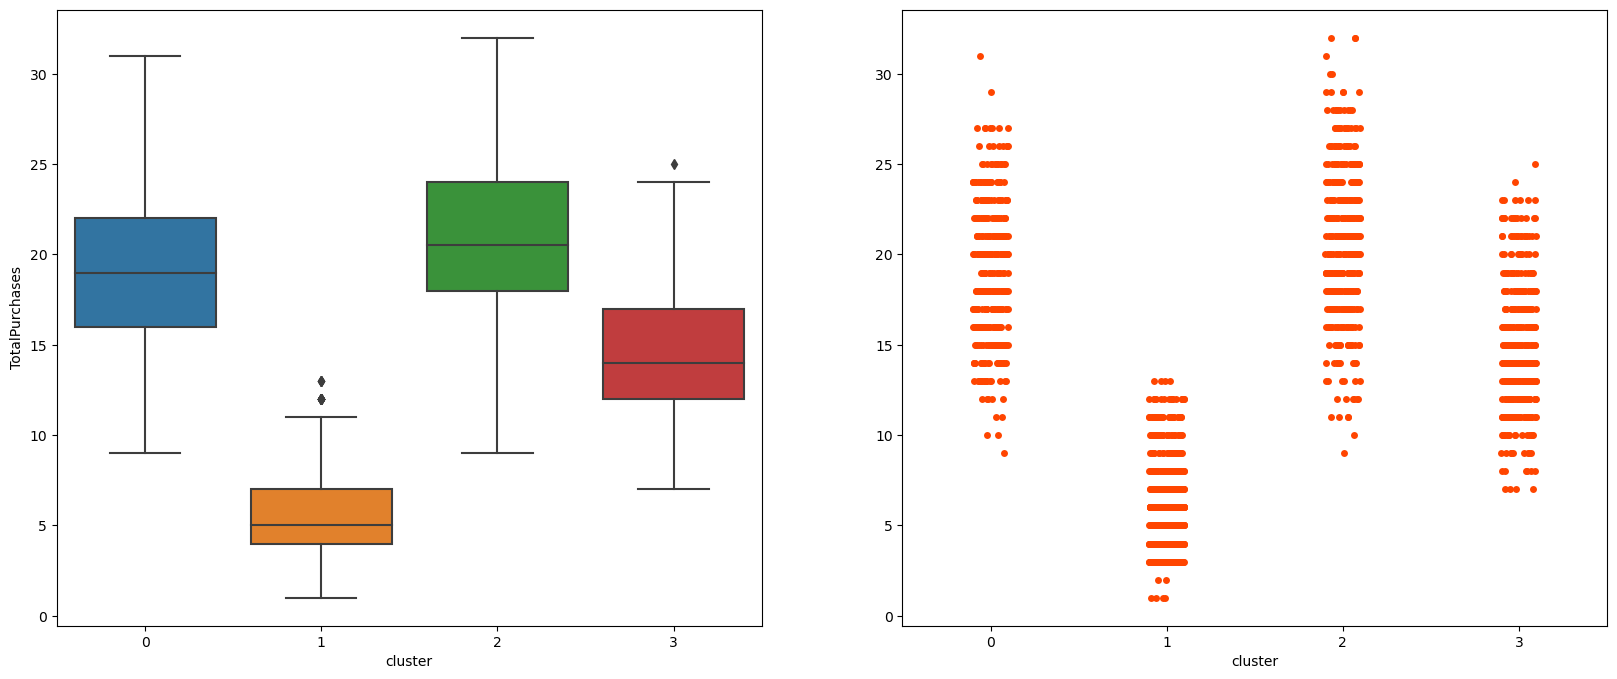

In [210]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='TotalPurchases', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('TotalPurchases')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='TotalPurchases', color='orangered', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

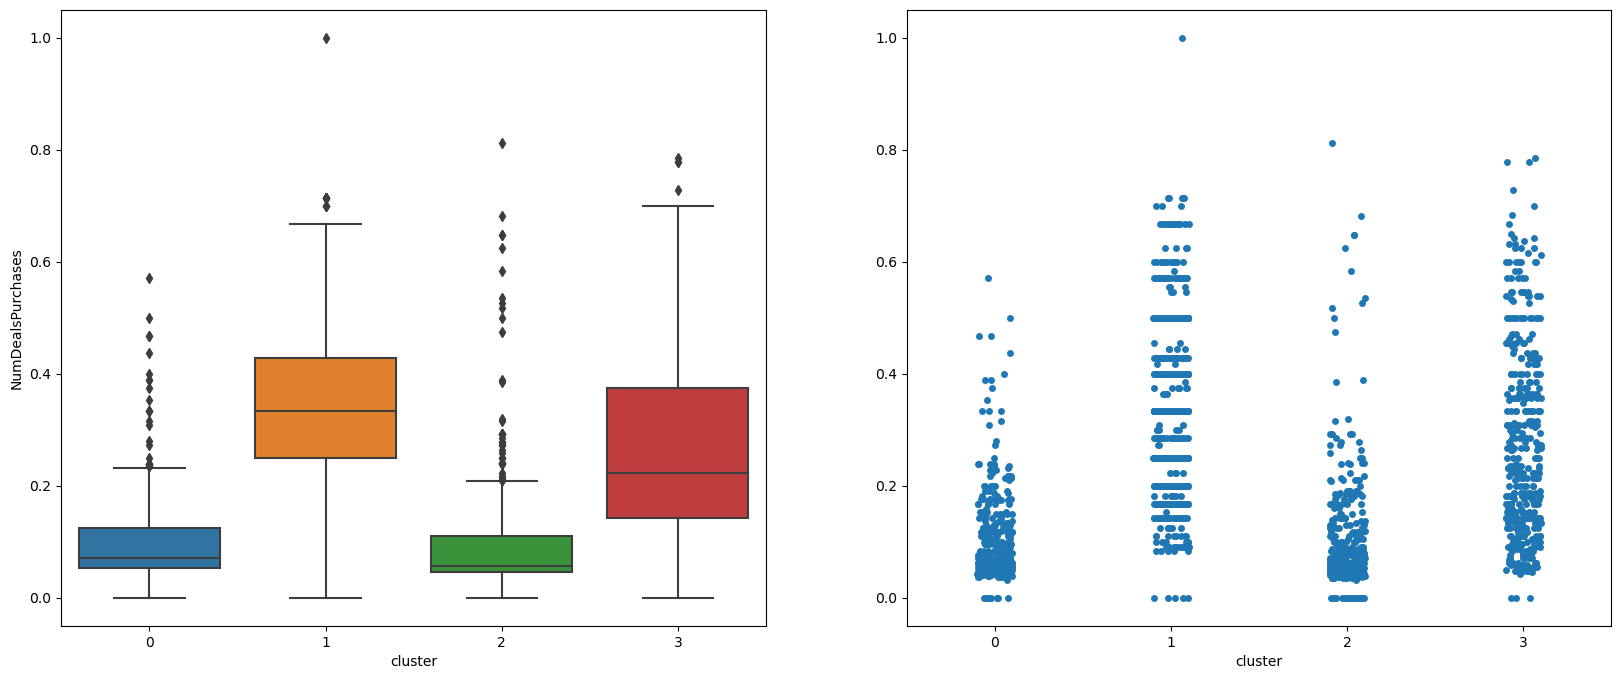

In [205]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='NumDealsPurchases', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('NumDealsPurchases')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='NumDealsPurchases', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

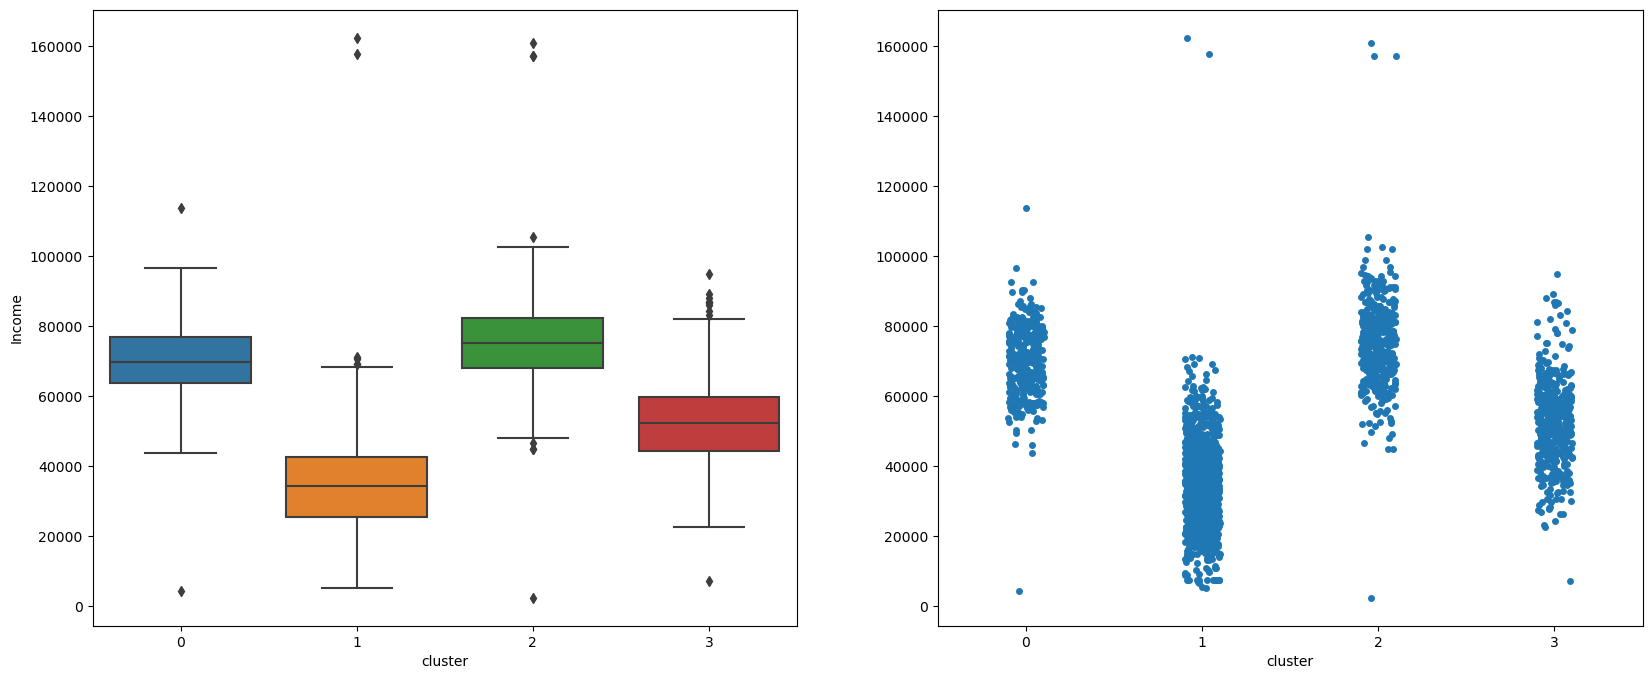

In [206]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='Income', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('Income')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='Income', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

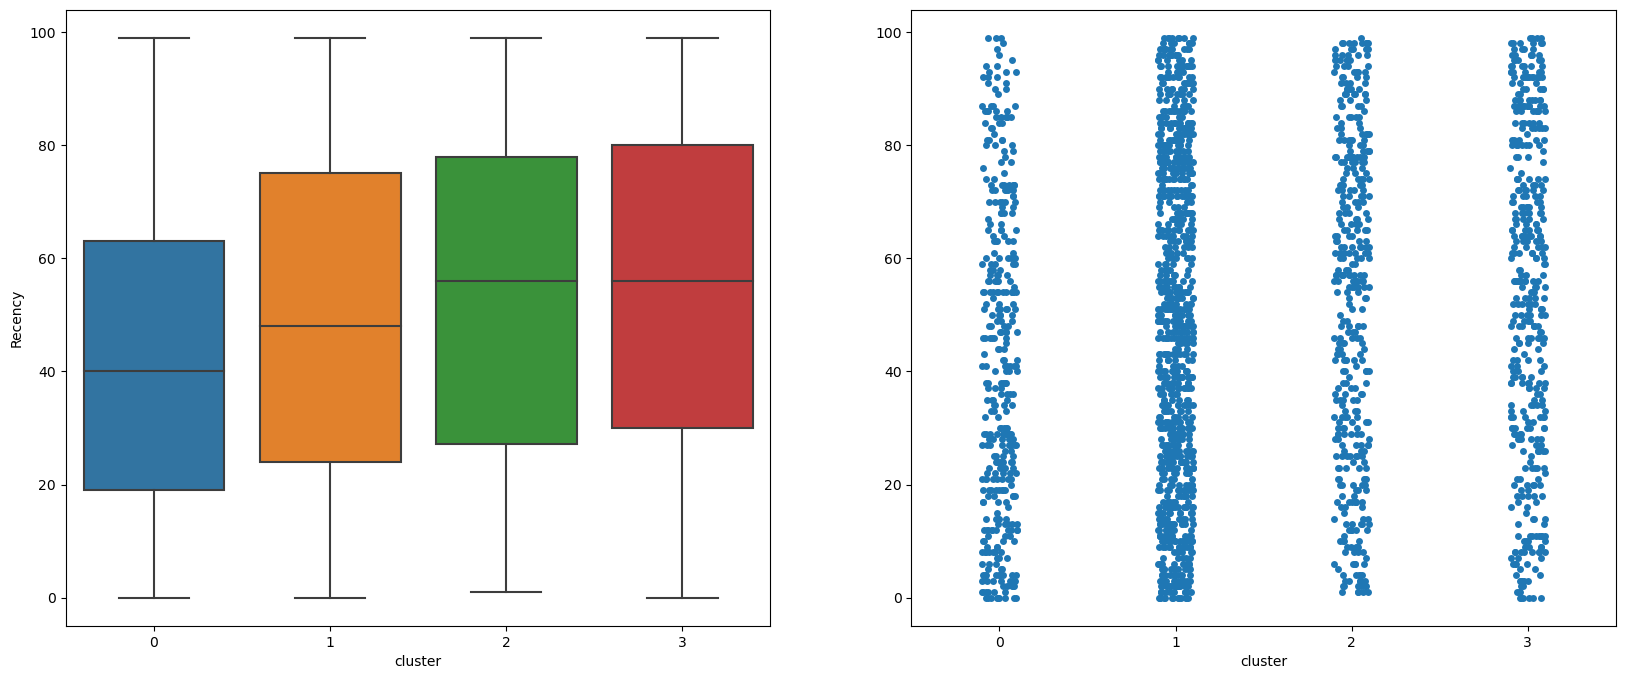

In [207]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='Recency', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('Recency')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='Recency', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

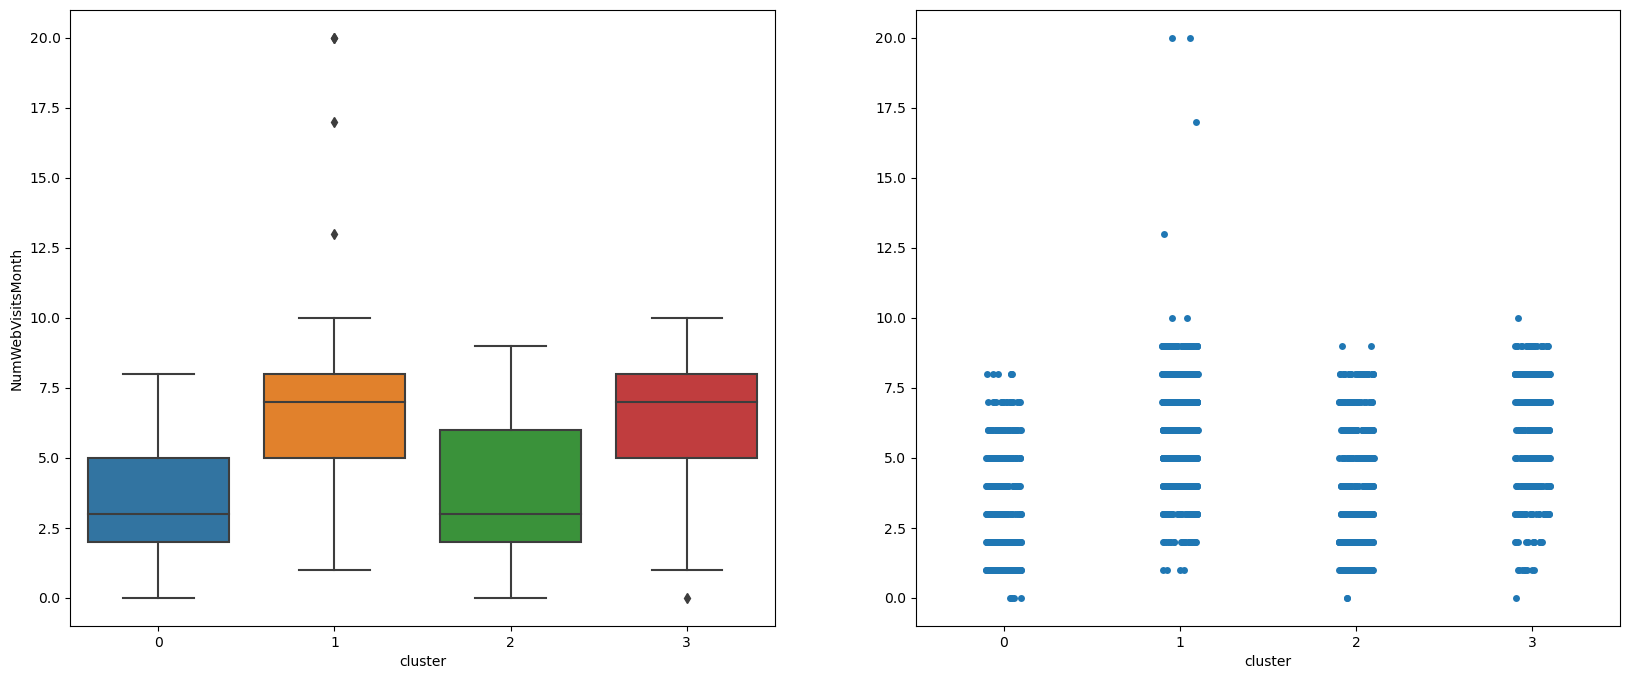

In [208]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='NumWebVisitsMonth', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('NumWebVisitsMonth')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='NumWebVisitsMonth', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()